In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymcfost as mcfost
import pandas as pd
import os
from astropy.io import fits
from matplotlib import rcParams
rcParams["figure.figsize"] = (5,2)

/home/jhyl3/.conda/envs/pyspedas/lib/python3.12/site-packages/pymcfost/SED.py:10: UserWarning: mpl_scatter_density is not present
  warnings.warn("mpl_scatter_density is not present", UserWarning)


In [2]:
temp = fits.open('default/data_th/Temperature.fits.gz')
grid = fits.open('default/data_disk/grid.fits.gz')
mass_density = fits.open('default/data_disk/dust_mass_density.fits.gz')
number_density = fits.open('default/data_disk/dust_particle_density.fits.gz')
gas_density = fits.open('default/data_disk/gas_density.fits.gz')
grain_sizes = fits.open('default/data_disk/grain_sizes.fits.gz')
grain_sizes_max = fits.open('default/data_disk/grain_sizes_max.fits.gz')
grain_sizes_min = fits.open('default/data_disk/grain_sizes_min.fits.gz')
grain_masses = fits.open('default/data_disk/grain_masses.fits.gz')
volume = fits.open('default/data_disk/volume.fits.gz')

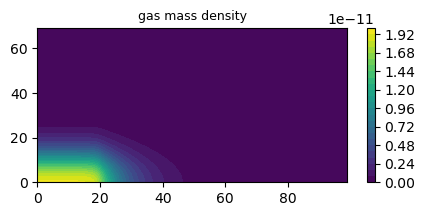

In [3]:
rcParams["figure.figsize"] = (5,2)
plt.contourf(gas_density[0].data, levels=30)
plt.title('gas mass density', fontsize=9)
plt.colorbar()

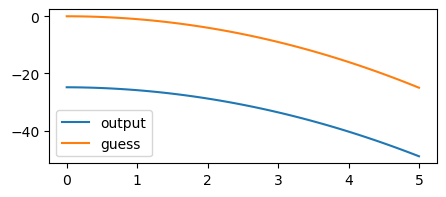

In [31]:
N = gas_density[0].header['NAXIS2']
plt.plot(np.linspace(0,10,N)/2, np.log(gas_density[0].data[:,20]), label='output')
plt.plot(np.linspace(0,10,N)/2, -(np.linspace(0,10,N)/2)**2, label='guess')
plt.legend()
# the gas density goes as exp(-z^2/4H^2)

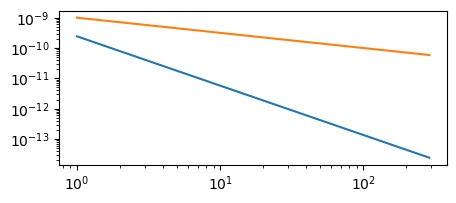

In [13]:
plt.plot(grid[0].data[0,0,0], np.sum(gas_density[0].data, axis=0))
plt.plot(grid[0].data[0,0,0], 1e-9*grid[0].data[0,0,0]**(-0.5))
plt.xscale('log')
plt.yscale('log')

In [20]:
print(number_density[0].header['UNIT'])
print(gas_density[0].header['UNIT'])

part.m^-3 [per grain size bin N(a).da]
g.cm^-3


### Comparing grain size distributions

In [8]:
grain_sizes_scaled = grain_sizes[0].data / 1e4 # convert from um to cm
amin = grain_sizes_min[0].data[0] / 1e4
amax = grain_sizes_max[0].data[-1] / 1e4

Text(0, 0.5, 'Proportional error')

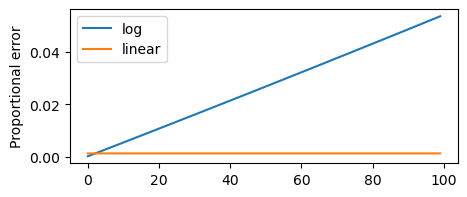

In [228]:
grain_size_list = np.logspace(np.log10(amin), np.log10(amax), 2*M)
plt.plot((grain_size_list[1:][::2] - grain_sizes_scaled)/grain_sizes_scaled, label='log')

grain_size_list = np.logspace(np.log10(amin), np.log10(amax), M+1)
plt.plot((((grain_size_list + 0.5*(np.roll(grain_size_list, -1) - grain_size_list))[:-1] - grain_sizes_scaled) / grain_sizes_scaled), label='linear')
plt.legend()
plt.ylabel('Proportional error')

# this shows that the grain sizes are logarithmically spaced but the average grain size is linearly spaced (in between min and max)

### Understanding the dust mass density

In [ ]:
P = gas_density[0].header['NAXIS1'] # number of radial cells
N = gas_density[0].header['NAXIS2'] # number of vertical cells

M = 100 # number of grain sizes
amin = 0.03 / 1e4 # in cm
amax = 1000 / 1e4 # in cm
aexp = 3.5

dust_mass = 1e-3 * 2e33 # in grams
g2d = 100 # gas-to-dust ratio
v2m_scale = (grain_masses[0].data / grain_sizes_scaled**3)[0] # is actually equal to 4pi/3 * 3.5 g/cm3
v2m_scale = 4*np.pi/3 * 3.5 # in g/cm3

Text(0.5, 1.0, 'Deviations from scaled gas density')

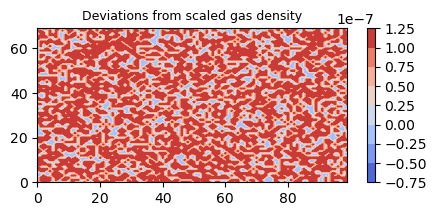

In [326]:
plt.contourf(mass_density[0].data*g2d/gas_density[0].data - 1, cmap='coolwarm')
plt.colorbar()
plt.title('Deviations from scaled gas density', fontsize=9)

Text(0.5, 1.0, 'Deviations from scaled dust mass density')

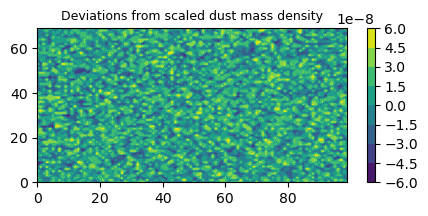

In [288]:
cumulative_mass = np.zeros((N,P))
for i in range(M):
    cumulative_mass+=number_density[0].data[i] * 1e-6 * grain_masses[0].data[i]
plt.contourf(cumulative_mass/mass_density[0].data - 1)
plt.colorbar()
plt.title('Deviations from scaled dust mass density', fontsize=9)

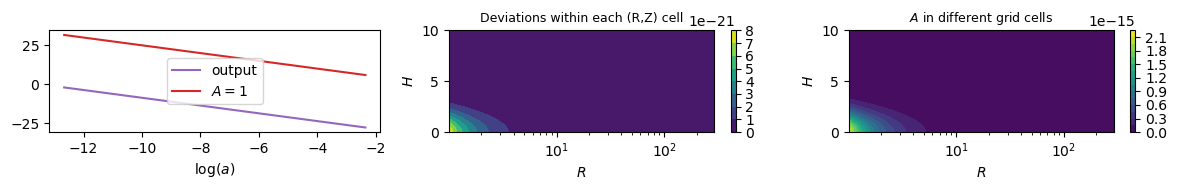

In [388]:
A_deviation = np.zeros((N,P))
for i in range(P):
    for j in range(N):
        A_list = np.exp(np.log(number_density[0].data[:,j,i] * 1e-6) + 2.5 * np.log(grain_sizes_scaled))
        A_deviation[j,i] = np.abs(np.max(A_list) - np.min(A_list))

A_grid = np.exp(np.log(number_density[0].data[0] * 1e-6) + 2.5 * np.log(grain_sizes_scaled[0]))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,2))
ax1.plot(np.log(grain_sizes_scaled), np.log(number_density[0].data[:,0,0] * 1e-6), label='output',c='C4')
ax1.plot(np.log(grain_sizes_scaled), - 2.5 * np.log(grain_sizes_scaled), label='$A=1$', c='C3')
ax1.legend()
ax1.set_xlabel('$\\log(a)$')
dev_cf = ax2.contourf(grid[0].data[0,0,0], np.linspace(0,10,N), A_deviation)
ax2.set_ylabel('$H$')
ax2.set_xscale('log')
ax2.set_xlabel('$R$')
ax2.set_title('Deviations within each (R,Z) cell', fontsize=9)
fig.colorbar(dev_cf, ax=ax2)
A_cf = ax3.contourf(grid[0].data[0,0,0], np.linspace(0,10,N), A_grid, levels=20)
fig.colorbar(A_cf, ax=ax3)
ax3.set_xlabel('$R$')
ax3.set_xscale('log')
ax3.set_ylabel('$H$')
ax3.set_title('$A$ in different grid cells', fontsize=9)
fig.tight_layout()

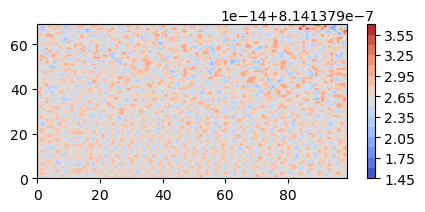

In [464]:
test_synthetic = []
for i in grain_sizes_scaled:
    test_synthetic.append(A_grid * i**(-aexp+1))
test_synthetic = np.array(test_synthetic)
plt.contourf(test_synthetic[0] / (number_density[0].data[0] * 1e-6) - 1, levels=20, cmap='coolwarm')
plt.colorbar()

### Generating the dust density from the gas density

In [13]:
dust_mass_density = gas_density[0].data / g2d # in g/cm^3
# A = dust_mass_density / (2/3 * v2m_scale * ( amax**(1.5) - amin**(1.5) )) # doesn't work
A1 = dust_mass_density / (np.sum(np.sqrt(grain_sizes_scaled)) * v2m_scale)

synthetic_particle_density = []
for i in grain_sizes_scaled:
    synthetic_particle_density.append(A1 * i**(-aexp+1))

synthetic_particle_density = np.array(synthetic_particle_density) # in number per m3

# plt.contourf(grid[0].data[0,0,0], np.linspace(0,10,N), (A1/A_grid-1), cmap='viridis', levels=20)
# plt.xscale('log')
# plt.colorbar()

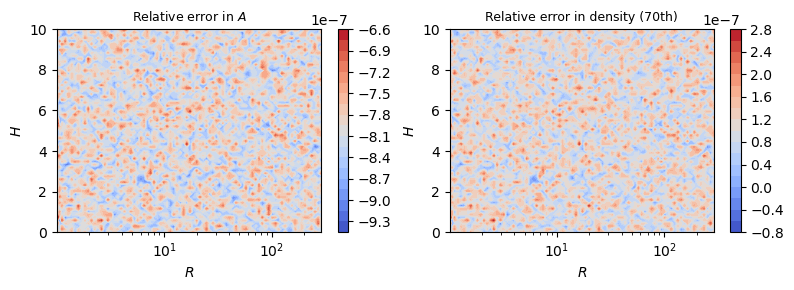

In [462]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
scaling_cf = ax1.contourf(grid[0].data[0,0,0], np.linspace(0,10,N), (A1/A_grid-1), cmap='coolwarm', levels=20)
ax1.set_xscale('log')
ax1.set_xlabel('$R$')
ax1.set_ylabel('$H$')
ax1.set_title('Relative error in $A$', fontsize=9)
density_cf = ax2.contourf(grid[0].data[0,0,0], np.linspace(0,10,N), synthetic_particle_density[m] / (number_density[0].data[m] * 1e-6) - 1, levels=20, cmap='coolwarm')
ax2.set_title('Relative error in density (70th)', fontsize=9)
ax2.set_xlabel('$R$')
ax2.set_ylabel('$H$')
ax2.set_xscale('log')
fig.tight_layout()
fig.colorbar(scaling_cf, ax=ax1)
fig.colorbar(density_cf, ax=ax2)
plt.show()

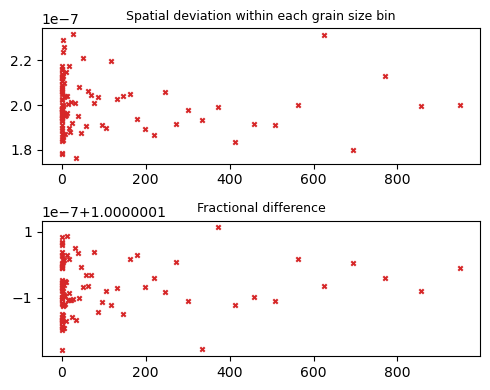

In [440]:
average_fractional_difference_list = [] # list the fractional difference as a function of grain size
max_deviation_list = [] # calculate the maximum deviation within each grain size bin

for i in range(M):
    fractional_difference = synthetic_particle_density[i] * 1e6 / number_density[0].data[i]
    average_fractional_difference = np.mean(fractional_difference)
    average_fractional_difference_list.append(average_fractional_difference)
    deviatoric_fractional_difference = fractional_difference - average_fractional_difference
    max_deviation = np.max(np.abs(deviatoric_fractional_difference))
    max_deviation_list.append(max_deviation)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(5,4))
ax1.scatter(grain_sizes[0].data, max_deviation_list, marker='x', s=10, c='C3')
ax1.set_title('Spatial deviation within each grain size bin', fontsize=9)
ax2.scatter(grain_sizes[0].data, average_fractional_difference_list, c='C3', marker='x', s=10)
ax2.set_title('Fractional difference', fontsize=9)
fig.tight_layout()

In [ ]:
# total dust density in terms of solar masses
np.sum(mass_density[0].data * volume[0].data * (1.5e13)**3) / 2e33

0.0010022470500982384